# Inverse Problems with Reinforcement Learning

This notebook trains reinforcement learning agents controlling Burgers' equation, a nonlinear PDE. The approach uses the reinforcement learning framework [stable_baselines3](https://github.com/DLR-RM/stable-baselines3) and the differentiable PDE solver [Φ<sub>Flow</sub>](https://github.com/tum-pbs/PhiFlow). [PPO](https://arxiv.org/abs/1707.06347v2) was chosen as reinforcement learning algorithm.

Additionally, a supervised control force estimator is trained as a performance baseline. This method was introduced by Holl et al. [\(2020\)](https://ge.in.tum.de/publications/2020-iclr-holl/).

In [ ]:
!pip install stable-baselines3 phiflow==1.5.1
!git clone https://github.com/Sh0cktr4p/PDE-Control-RL.git
!git clone https://github.com/holl-/PDE-Control.git

## Training

In [ ]:
import sys; sys.path.append('PDE-Control/src'); sys.path.append('PDE-Control-RL/src')
import time
import csv
import os
import shutil
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from phi.flow import *
import burgers_plots as bplt
import matplotlib.pyplot as plt
from envs.burgers_util import GaussianClash, GaussianForce

## Data Generation

At first we generate a dataset to train the CFE model on and evaluate the performance of both approaches during and after training.

In [ ]:
domain = Domain([32], box=box[0:1])     # Defines the size of the fields
viscosity = 0.003
step_count = 32                         # Trajectory length
dt = 0.03
diffusion_substeps = 1

data_path = 'forced-burgers-clash'
scene_count = 1000
batch_size = 100

train_range = range(200, 1000)
val_range = range(100, 200)
test_range = range(0, 100)

In [ ]:
for batch_index in range(scene_count // batch_size):
    scene = Scene.create(data_path, count=batch_size)
    print(scene)
    world = World()
    u0 = BurgersVelocity(
        domain, 
        velocity=GaussianClash(batch_size), 
        viscosity=viscosity, 
        batch_size=batch_size, 
        name='burgers'
    )
    u = world.add(u0, physics=Burgers(diffusion_substeps=diffusion_substeps))
    force = world.add(FieldEffect(GaussianForce(batch_size), ['velocity']))
    scene.write(world.state, frame=0)
    for frame in range(1, step_count + 1):
        world.step(dt=dt)
        scene.write(world.state, frame=frame)

## Reinforcement Learning Training

In [ ]:
from experiment import BurgersTraining

In [ ]:
n_envs = 10                         # On how many environments to train in parallel, load balancing
final_reward_factor = step_count    # How hard to punish the agent for not reaching the goal if that were the case
steps_per_rollout = step_count * 10 # How many steps to collect per environment between agent updates
n_epochs = 10                       # How many epochs to perform during agent update
rl_learning_rate = 1e-4             # Learning rate for agent updates
rl_batch_size = 128                 # Batch size for agent updates

To start training, we create a trainer object which manages the environment and the agent internally. Additionally, a directory for storing models, logs, and hyperparameters is created. This way, training can be continued at any later point using the same configuration. If the model folder specified in exp_name already exists, the agent within is loaded. Otherwise, a new agent is created.

As default, a already trained agent stored at PDE-Control-RL/networks/rl-models/bench is loaded. To generate a new model, replace the specified path with another.

In [ ]:
rl_trainer = BurgersTraining(
    path='PDE-Control-RL/networks/rl-models/bench', # Replace this to train a new model
    domain=domain,
    viscosity=viscosity,
    step_count=step_count,
    dt=dt,
    diffusion_substeps=diffusion_substeps,
    n_envs=n_envs,
    final_reward_factor=final_reward_factor,
    steps_per_rollout=steps_per_rollout,
    n_epochs=n_epochs,
    learning_rate=rl_learning_rate,
    batch_size=rl_batch_size,
    data_path=data_path,
    val_range=val_range,
    test_range=test_range,
)

Loading existing agent from PDE-Control-RL/networks/rl-models/bench/agent.zip


The following cell opens tensorboard inside the notebook to display the progress of the training. If a new model was created at a different location, please change the path to the location at which you stored your model.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir PDE-Control-RL/networks/rl-models/bench/tensorboard-log

Now we are set up to start training the agent. The next cell might take multiple hours to execute, depending on the number of rollouts (around 6h for 1000 iterations)

In [ ]:
rl_trainer.train(n_rollouts=1000, save_freq=50)

Now let us take a quick glance about what the results look like.
Here also an example for a trajectory after around 3600 training iterations:
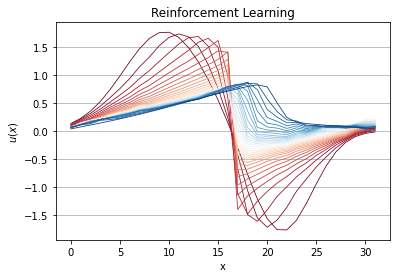

In [ ]:
rl_frames, _, _ = rl_trainer.infer_test_set_frames()

index_in_set = 0    # Change this to display a reconstruction of another scene

bplt.burgers_figure('Reinforcement Learning')
for frame in range(0, step_count + 1):
    plt.plot(rl_frames[frame][index_in_set,:], color=bplt.gradient_color(frame, step_count+1), linewidth=0.8)

## Control Force Estimator Training

To classify the results of the reinforcement learning method, they are compared to a supervised control force estimator approach using differentiable physics loss. This comparison seems reasonable, as both approaches work by optimizing through trial and error.

The CFE approach has access to the gradient data provided by the differentiable solver, making it possible to trace the loss over multiple timesteps and enabling the model to comprehend long term effects of generated forces better.

The reinforcement learning approach on the other hand uses a dedicated value estimator network (critic) to predict the sum of rewards generated from a certain state. These are then used to update a policy network (actor) which, analogously to the control force estimator network, predicts the forces to control the simulation. The reinforcement learning algorithm is not limited by training set size like the CFE approach, as new training samples are generated on policy. However, this also introduces additional simulation overhead during training, which can increase the time needed for convergence. 

In [ ]:
from control.pde.burgers import BurgersPDE
from control.control_training import ControlTraining
from control.sequences import StaggeredSequence

The cell below sets up a model for training or to load an existing model checkpoint.

In [ ]:
cfe_app = ControlTraining(
    step_count,
    BurgersPDE(domain, viscosity, dt),
    datapath=data_path,
    val_range=val_range,
    train_range=train_range,
    trace_to_channel=lambda trace: 'burgers_velocity',
    obs_loss_frames=[],
    trainable_networks=['CFE'],
    sequence_class=StaggeredSequence,
    batch_size=100,
    view_size=20,
    learning_rate=1e-3,
    learning_rate_half_life=1000,
    dt=dt
).prepare()

The cell below executes the model training. Please specify a number of iterations for the algorithm to run.

In [ ]:
cfe_training_eval_data = []

start_time = time.time()

for epoch in range(200):
    cfe_app.progress()
    # Evaluate validation set at regular intervals to track learning progress
    # Size of intervals determined by RL epoch count per iteration for accurate comparison
    if epoch % n_epochs == 0:
        f = cfe_app.infer_scalars(val_range)['Total Force'] / dt
        cfe_training_eval_data.append((time.time() - start_time, epoch, f))

The following cells stores the trained model and the validation performance with respect to iterations and wall time.

In [ ]:
cfe_store_path = 'networks/cfe-models/bench'
if not os.path.exists(cfe_store_path):
    os.makedirs(cfe_store_path)

# store training progress information
with open(os.path.join(cfe_store_path, 'val_forces.csv'), 'at') as log_file:
    logger = csv.DictWriter(log_file, ('time', 'epoch', 'forces'))
    logger.writeheader()
    for (t, e, f) in cfe_training_eval_data:
        logger.writerow({'time': t, 'epoch': e, 'forces': f})

cfe_checkpoint = cfe_app.save_model()
shutil.move(cfe_checkpoint, cfe_store_path)

Alternatively, run the cell below can be run to load an existing network model.

In [ ]:
cfe_path = 'PDE-Control-RL/networks/cfe-models/bench/checkpoint_00020000/'
networks_to_load = ['OP2', 'OP4', 'OP8', 'OP16', 'OP32']

cfe_app.load_checkpoints({net: cfe_path for net in networks_to_load})

Run the cell below to see how the algorithm performs. Here is an example of a model trained for 2000 iterations:
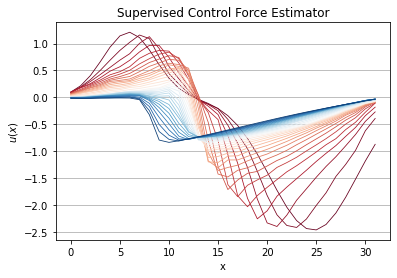

In [ ]:
cfe_frames = cfe_app.infer_all_frames(test_range)

index_in_set = 1    # Change this to display a reconstruction of another scene

bplt.burgers_figure('Supervised Control Force Estimator')
for frame in range(0, step_count + 1):
    plt.plot(cfe_frames[frame].burgers.velocity.data[index_in_set,:,0], color=bplt.gradient_color(frame, step_count+1), linewidth=0.8)

## Comparison

Next, the results of both methods are compared in terms of visual quality of the resulting trajectories as well as the generated forces. The latter provides insight about the performance of either approaches as both aspire to minimize this metric during training

In [ ]:
import utils
import pandas as pd

## Trajectory Comparison

To compare the resulting trajectories, we generate trajectories from the test set with each method. Also, we collect the ground truth simulations and the natural evolution of the test set fields.

In [ ]:
rl_frames, gt_frames, unc_frames = rl_trainer.infer_test_set_frames()

cfe_frames = cfe_app.infer_all_frames(test_range)
cfe_frames = [s.burgers.velocity.data for s in cfe_frames]

frames = {
    (0, 0): ('Ground Truth', gt_frames),
    (0, 1): ('Uncontrolled', unc_frames),
    (1, 0): ('Reinforcement Learning', rl_frames),
    (1, 1): ('Supervised Control Force Estimator', cfe_frames),
}

In [ ]:
index_in_set = 0    # Specifies which sample of the test set should be displayed

def plot(axs, xy, title, field):
    axs[xy].set_ylim(-2, 2)
    axs[xy].set_xlabel('x')
    axs[xy].set_ylabel('u(x)')
    axs[xy].set_title(title)

    label = 'Initial state in dark red, final state in dark blue'

    for step_idx in range(0, step_count + 1):
        color = bplt.gradient_color(step_idx, step_count+1)
        axs[xy].plot(
            field[step_idx][index_in_set].squeeze(), 
            color=color, 
            linewidth=0.8, 
            label=label
        )
        label = None

    axs[xy].legend()

fig, axs = plt.subplots(2, 2, figsize=(12.8, 9.6))

for xy in frames:
    plot(axs, xy, *frames[xy])

## Forces Comparison

Next, we compute the forces the approaches have generated for the test set trajectories.

In [ ]:
gt_forces = utils.infer_forces_sum_from_frames(
    gt_frames, domain, diffusion_substeps, viscosity, dt
)
cfe_forces = utils.infer_forces_sum_from_frames(
    cfe_frames, domain, diffusion_substeps, viscosity, dt
)
rl_forces = rl_trainer.infer_test_set_forces()

In the following, the forces generated by both methods are compared to the ground truth of the respective sample. Samples placed above the blue line denote stronger forces in the used deep learning approach than in the ground truth and vice versa.

In [ ]:
plt.figure(figsize=(12.8, 9.6))
plt.scatter(gt_forces, cfe_forces, label='CFE')
plt.scatter(gt_forces, rl_forces, label='RL')
plt.plot([x * 100 for x in range(15)], [x * 100 for x in range(15)], label='Same forces as original')
plt.xlabel('ground truth')
plt.xlim(0, 1500)
plt.ylim(0, 1500)
plt.ylabel('reconstruction')
plt.grid()
plt.legend()

Next, the two deep learning methods are compared directly. Samples above the line denote higher forces by the control force estimator, samples below higher forces for the reinforcement learning agent.

In [ ]:
plt.figure(figsize=(12.8, 9.6))
plt.scatter(rl_forces, cfe_forces)
plt.xlabel('Reinforcement Learning')
plt.ylabel('Control Force Estimator')
plt.plot([x * 100 for x in range(15)], [x * 100 for x in range(15)], label='Same forces cfe rl')
plt.xlim(0, 1500)
plt.ylim(0, 1500)
plt.grid()
plt.legend()

The following plot displays the performance of all reinforcement learning, control force estimator and ground truth with respect to individual samples.

In [ ]:
w=0.25
plot_count=20
plt.figure(figsize=(12.8, 9.6))
plt.bar(
    [i - w for i in range(plot_count)], 
    rl_forces[:plot_count], 
    width=w, 
    align='center', 
    label='RL'
)
plt.bar(
    [i + w for i in range(plot_count)], 
    cfe_forces[:plot_count], 
    width=w, 
    align='center', 
    label='CFE'
)
plt.bar(
    [i for i in range(plot_count)], 
    gt_forces[:plot_count], 
    width=w, 
    align='center', 
    label='GT'
)
plt.xlabel('Scenes')
plt.xticks(range(plot_count))
plt.ylabel('Forces')
plt.legend()
plt.show()

## Training Progress Comparison

This cell explores the training progress of both methods with respect to iterations and wall time.

In [ ]:
def get_cfe_val_set_forces(experiment_path):
    path = os.path.join(experiment_path, 'val_forces.csv')
    table = pd.read_csv(path)
    return list(table['time']), list(table['epoch']), list(table['forces'])

rl_w_times, rl_step_nums, rl_val_forces = rl_trainer.get_val_set_forces_data()
cfe_w_times, cfe_epochs, cfe_val_forces = get_cfe_val_set_forces('PDE-Control-RL/networks/cfe-models/bench')

fig, axs = plt.subplots(2, 1, figsize=(12.8, 9.6))

axs[0].plot(np.array(rl_step_nums), rl_val_forces, label='RL')
axs[0].plot(np.array(cfe_epochs), cfe_val_forces, label='CFE')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Forces')
axs[0].set_ylim(0, 1500)
axs[0].grid()
axs[0].legend()

axs[1].plot(np.array(rl_w_times) / 3600, rl_val_forces, label='RL')
axs[1].plot(np.array(cfe_w_times) / 3600, cfe_val_forces, label='CFE')
axs[1].set_xlabel('Wall time (hours)')
axs[1].set_ylabel('Forces')
axs[1].set_ylim(0, 1500)
axs[1].grid()
axs[1].legend()